#### Проведем A/B тест. В группе 2 был использован новый алгоритм рекомендации постов, группа 1 использовалась в качестве контроля. 
##### Основная гипотеза - новый алгоритм во 2-й группе приведет к увеличению CTR. 
##### Необходимо: 
##### Выбрать метод анализа и сравнить CTR в двух группах;
##### сделать вывод.

In [2]:
# Подключаемся в БД.
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20231220',
'user':'student',
'password':'dpo_python_2020'
}

In [3]:
# Загружаем библиотеки и модули.
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib
import swifter
from scipy import stats
%matplotlib inline

In [4]:
# Выгружаем данные из БД.
q = '''
select  exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
from {db}.feed_actions
where toDate(time) >= '2023-11-18' and toDate(time) <= '2023-11-24' and  exp_group in (2,1)
GROUP BY exp_group, user_id
'''
df = ph.read_clickhouse(q, connection=connection)

In [5]:
df

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,18392,7,32,0.218750
4,1,26295,39,141,0.276596
...,...,...,...,...,...
19892,2,17146,0,10,0.000000
19893,1,30872,11,59,0.186441
19894,2,25383,42,127,0.330709
19895,2,139020,17,41,0.414634


In [6]:
# Фрмируем группы.
group_A = df[df.exp_group	== 2].copy()
group_B = df[df.exp_group	== 1].copy()

In [7]:
# Применяем т-тест.
stats.ttest_ind(group_A.ctr, group_B.ctr, equal_var = False)


Ttest_indResult(statistic=-0.4051491913112757, pvalue=0.685373331140751)

In [8]:
# По результатам т-теста недостаточно оснований сказать, чото отличия между CTR есть.

In [9]:
# Сделаем сглаженный CTR.
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

global_ctr_A= df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()
global_ctr_B = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()

In [10]:
group_A['smoothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_A, 5), axis = 1)

In [11]:
group_B['smoothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_B, 5), axis = 1)

In [12]:
# Применяем т-тест для сравнения сглаженного ctr.
stats.ttest_ind(group_A.smoothed_ctr, group_B.smoothed_ctr, equal_var = False)

Ttest_indResult(statistic=-1.9460491517027683, pvalue=0.05166679015318526)

In [13]:
# По результатам т-теста на сглаженном ctr есть основания отвергнуть нулевую гипотезу о равенстве распределений. Однако сам \
# сглаженный ctr не имеет теоретических гарантий.

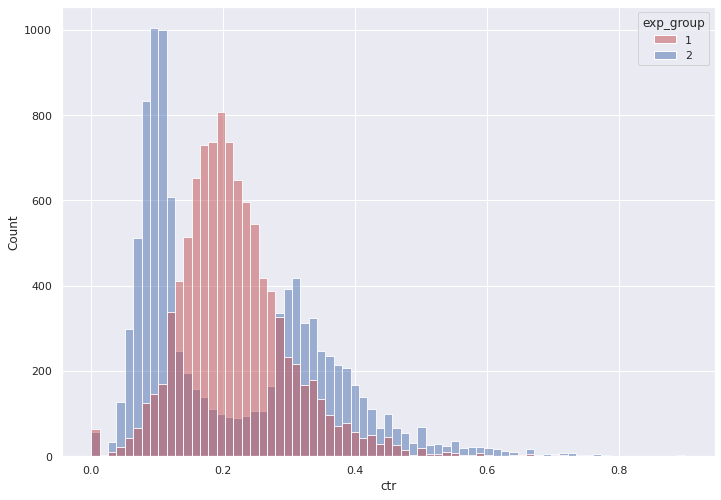

In [14]:
# Сделаем визуализацию.
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [15]:
# По графику видим, что различия есть, но, возможно, т-тест не замечает их.

In [16]:
# Проведем bootstrap.

<Axes: ylabel='Count'>

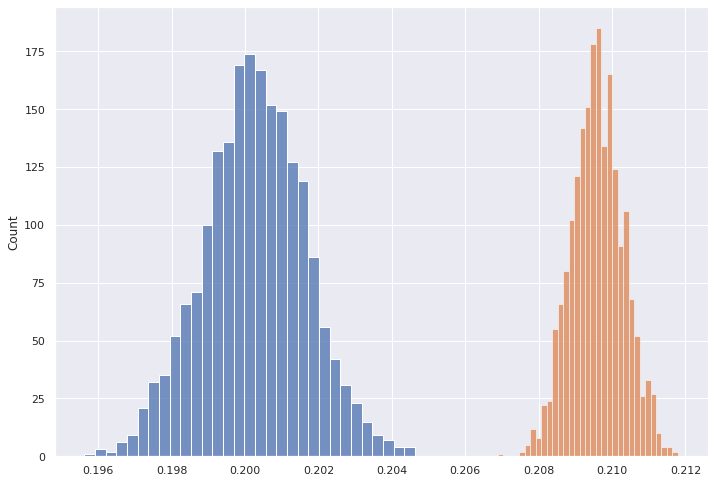

In [17]:
# Функция для bootstrap.
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2


likes1 = df[df.exp_group == 2].likes.to_numpy()
views1 = df[df.exp_group == 2].views.to_numpy()
likes2 = df[df.exp_group == 1].likes.to_numpy()
views2 = df[df.exp_group == 1].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

In [18]:
# По результатам бутстрапа новый алгоритм значимо хуже, чем старый, если мы сравниваем ctr.

In [19]:
# Сделаем бакетное преобразование.

In [23]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
where toDate(time) >= '2023-11-18' and toDate(time) <= '2023-11-24' and  exp_group in (2,1)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_bucket = ph.read_clickhouse(q, connection=connection)

# Применяем тест Манна-Уитни.
stats.mannwhitneyu(df_bucket[df_bucket.exp_group == 2].bucket_ctr, 
                   df_bucket[df_bucket.exp_group == 1].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=503.0, pvalue=2.6576427804010095e-07)

In [ ]:
#тест Манна-Уитни видит значимое отличие.

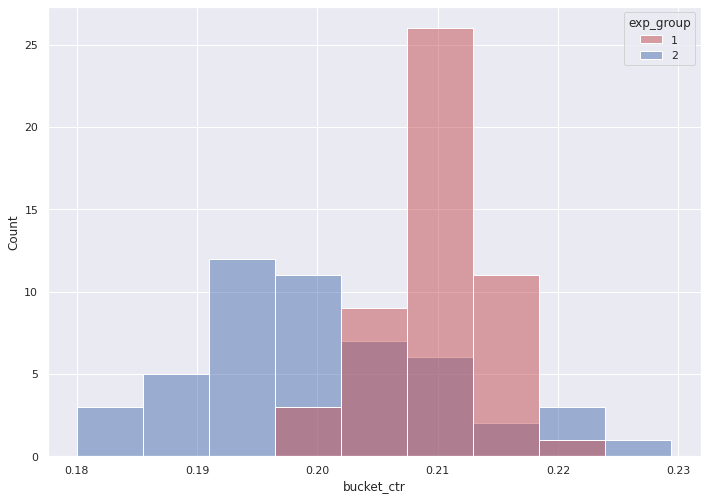

In [26]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
groups = sns.histplot(data = df_bucket, 
              x='bucket_ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [27]:
# Построив график, убеждаемся, что контрольная группа находится правеe тестовой, и CTR у нее больше.

#### Вывод: пока не следует раскатывать новый алгоритм рекомендаций на всех пользователей. Он требут дополнительной прработки и исследования.